In [12]:

# import matplotlib
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 

# import sklearn
# from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score
import numpy.random as r

Preprocessing the data!

In [25]:
file_path = "rf_signal_data.csv"
rf_data = pd.read_csv(file_path)

#check how the data looks
#print(rf_data)
dnnd = 7
#Let's hot encode the modulation types, weather conditions, interference type, Antenna Type, and device status using integers
label_encoder = LabelEncoder()
rf_data['Modulation_Original'] = rf_data['Modulation']
rf_data['Modulation'] = label_encoder.fit_transform(rf_data['Modulation']) + 1  # Add 1 to avoid 0 indexing
rf_data['Interference Type'] = label_encoder.fit_transform(rf_data['Interference Type']) + 1
rf_data['Weather Condition'] = label_encoder.fit_transform(rf_data['Weather Condition']) + 1
rf_data['Device Status'] = label_encoder.fit_transform(rf_data['Device Status']) + 1
rf_data['Antenna Type'] = label_encoder.fit_transform(rf_data['Antenna Type']) + 1
rf_data['Device Type'] = label_encoder.fit_transform(rf_data['Device Type']) + 1
# print(rf_data)

X = rf_data.loc[:,~rf_data.columns.isin(['Device Status','Modulation','Timestamp','Location','Latitude','Longitude','Altitude','Air Pressure','I/Q Data','Modulation_Original','Weather Condition','Antenna Type', 'Battery Level' ])]
y = rf_data['Modulation']

#Split the data into test data and validation data
X_train, X_test, y_train, y_test = train_test_split( X, y,random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X)
print(X_train)

        Frequency  Signal Strength  Bandwidth  Device Type  Temperature  \
0       120000000              -44      50000            1           24   
1       160000000              -97    1000000            1           27   
2        90000000              -87     500000            2           40   
3       160000000              -29     100000            2           28   
4        70000000              -26      10000            1           22   
...           ...              ...        ...          ...          ...   
164155  160000000              -63     200000            3           31   
164156  120000000              -15      10000            2           28   
164157  160000000              -97      10000            2           25   
164158  120000000              -29     500000            3           28   
164159   70000000              -68     100000            1           23   

        Humidity  Wind Speed  Precipitation  Interference Type  Power Source  \
0             47   

# Supervised Analysis I: Logistic Regression

Process the data so that we can perform logistic regression:

In [14]:
ones = np.ones((X_train.shape[0],1))
ones2 = np.ones((X_test.shape[0],1))
X_train_logistic = np.hstack((ones,X_train))
X_test_logistic = np.hstack((ones2,X_test))

y_2d_train = np.array(y_train).reshape(-1, 1)
y_2d_test = np.array(y_test).reshape(-1, 1)

enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(y_2d_train)
y_2d_train_log = enc.transform(y_2d_train).toarray()
print(y_2d_train_log.shape)

enc.fit(y_2d_test)
y_2d_test_log = enc.transform(y_2d_test).toarray()
print(y_2d_test_log.shape)

(123120, 6)
(41040, 6)


Define the necessary functions:

In [15]:
#sigmoid function
def sigmoid(z):
  return 1/(1+np.exp(-z))
# print(sigmoid(0))

w_init = np.random.randn(X_train_logistic.shape[1],1)

#print(w_init)

#hypothesis function
def hypothesis(X, w):
    return sigmoid(X.dot(w)) #check over if models not working

# y_hat_init = hypothesis(X_train_logistic,w_init)

def log_likelihood(X, y, w):
    z = hypothesis(X,w)
    result = ((y*(np.log(z))) + (1-y)*np.log(1-z)).sum()

    return result # you should return a real number, not a list containing a real number

# Write the gradient ascent function
def Gradient_Ascent(X, y, learning_rate, num_iters):
    # We assume X has been augmented with a column of ones

    # Number of training examples.
    N = X.shape[0]

    # Initialize w(<np.ndarray>). Zeros vector of shape X.shape[1],1
    w = np.zeros((X.shape[1],y.shape[1]))

    # Initiating list to store values of likelihood(<list>) after few iterations.
    log_likelihood_values = []

    # Gradient Ascent - local optimization technique
    for i in range(num_iters):
        w += (learning_rate/N)*((X.T).dot(y-hypothesis(X,w)))
        # Computing log likelihood of seeing examples for current value of w
        if (i % 10) == 0:
            log_likelihood_values.append(log_likelihood(X, y, w))
            #print(log_likelihood(X, y, w))

    return w, log_likelihood_values



Let's try different learning rates and iteration values:

In [16]:
# Please try many different values for the learning rate (including very small values).
learning_rate = 0.01
num_iters = 500
# Calculate w and likelihood values using Gradient_Ascent with X_train_1, y_2d_train
w, log_likelihood_values = Gradient_Ascent(X_train_logistic, y_2d_train, learning_rate, num_iters)
# print(log_likelihood_values)

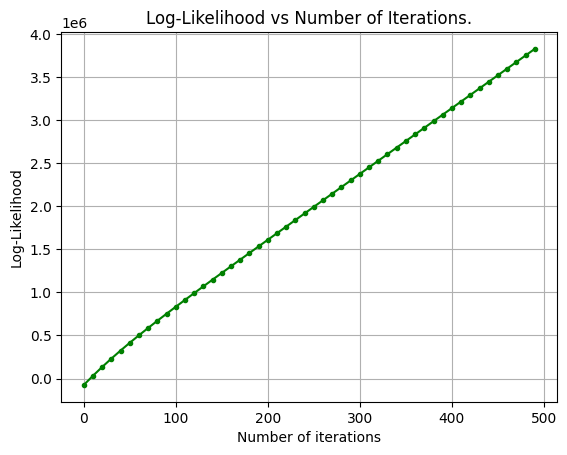

In [17]:
iters = np.array(range(0,num_iters,10))
# iters = np.array(range(num_iters))
plt.plot(iters,log_likelihood_values,'.-',color='green')
plt.xlabel('Number of iterations')
plt.ylabel('Log-Likelihood')
plt.title("Log-Likelihood vs Number of Iterations.")
plt.grid()
plt.show(block=False)


Let's predict Modulation Classes using Soft-max logistic regression

(41040, 6) (41040, 6) (123120, 6)


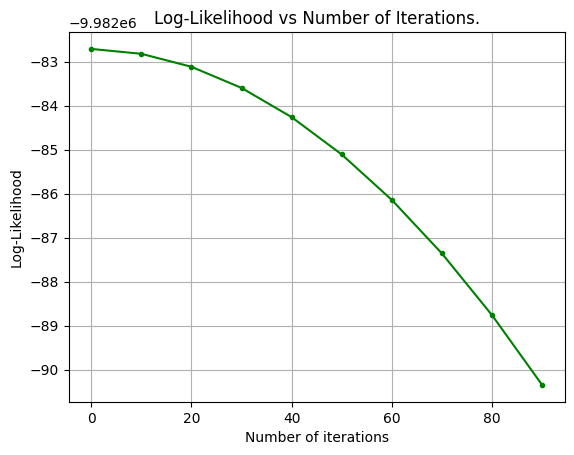

[[4.03153493e-06 4.05082998e-06 4.10701738e-06 4.07908539e-06
  4.04691670e-06 4.05114607e-06]
 [4.01129220e-06 4.03203386e-06 4.08355457e-06 4.06174942e-06
  4.07686986e-06 4.10127735e-06]
 [4.06534567e-06 4.06323298e-06 4.06572000e-06 4.06019560e-06
  4.07300998e-06 4.03865586e-06]
 ...
 [4.04246951e-06 4.03698258e-06 4.04561397e-06 4.06717751e-06
  4.09738116e-06 4.07679042e-06]
 [4.03190387e-06 4.05855845e-06 4.08567350e-06 4.08032835e-06
  4.04098396e-06 4.06890994e-06]
 [4.06101249e-06 4.06101249e-06 4.06101249e-06 4.06101249e-06
  4.06101249e-06 4.06101249e-06]]


In [21]:
#check one hot encoding
# print(y_2d_train_log)

#reshape w_init for softmax
# w_init = np.random.randn(X_train_logistic.shape[1],y_2d_test_log.shape[1])
w_init = np.zeros((X_train_logistic.shape[1],y_2d_test_log.shape[1]))


# print(w_init)
# print(w_init.shape)

#define softmax function
def softmax(X,w):
    xw = X.dot(w)
    e_x = np.exp(xw - xw[-1])
    return e_x / e_x.sum()

#define log_likelihood
def log_likelihood(X, y, w):
    p_scores = softmax(X,w)
    result = (y.T.dot(np.log(p_scores))).sum()

    return result

#define new Gradient Ascent Function
def Gradient_Ascent(X, y, learning_rate, num_iters):
    # We assume X has been augmented with a column of ones

    # Number of training examples.
    N = X.shape[0]

    # Initialize w(<np.ndarray>). Zeros vector of shape X.shape[1],1
    w = np.zeros((X.shape[1],y.shape[1]))

    # Initiating list to store values of likelihood(<list>) after few iterations.
    log_likelihood_values = []

    # Gradient Ascent - local optimization technique
    for i in range(num_iters):
        w += (learning_rate/N)*((X.T).dot(y-softmax(X,w)))
        # Computing log likelihood of seeing examples for current value of w
        if (i % 10) == 0:
            log_likelihood_values.append(log_likelihood(X, y, w))
            #print(log_likelihood(X, y, w))

    return w, log_likelihood_values

# print(log_likelihood(X_train_logistic,y_2d_train_log,w_init))

# Please try many different values for the learning rate (including very small values).
learning_rate = .01
num_iters = 100
# Calculate w and likelihood values using Gradient_Ascent with X_train_1, y_2d_train
w, log_likelihood_values = Gradient_Ascent(X_train_logistic, y_2d_train_log, learning_rate, num_iters)
# print(w, log_likelihood_values)
y_result_test = softmax(X_test_logistic,w)

# correct = 0
# for i in range(y_result_test.shape[0]):
#   if np.argmax(y_result_test[i, :]) == np.argmax(y_2d_test[i, :]):
#     correct += 1
# accuracy = correct / y_result_test.shape[0]
# print(accuracy)


# print(y_2d_test.shape, y_result_test.shape)
# for i in range(y_result_test.shape[0]):
#   y_result_test[i, :] = np.argmax(y_result_test[i, :])
#   y_2d_test[i, :] = np.argmax(y_2d_test[i, :])
# print(y_2d_test.shape, y_result_test.shape)



print(y_2d_test_log.shape, y_result_test.shape, y_2d_train_log.shape)


correct = 0
for i in range(y_result_test.shape[0]):
  if np.argmax(y_result_test[i, :]) == np.argmax(y_2d_test_log[i, :]):
    correct += 1
accuracy = correct / y_result_test.shape[0]
# print(accuracy)

# accuracy = accuracy_score(y_2d_test_log, y_result_test)

iters = np.array(range(0,num_iters,10))
plt.plot(iters,log_likelihood_values,'.-',color='green')
plt.xlabel('Number of iterations')
plt.ylabel('Log-Likelihood')
plt.title("Log-Likelihood vs Number of Iterations.")
plt.grid()
plt.show(block=False)

print(y_result_test)